In [1]:
import tushare as ts
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn import metrics,linear_model,svm,preprocessing,tree,ensemble,naive_bayes,neighbors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve,cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import ta
import random
import seaborn as sns
from datetime import datetime 

# Loading Data

#since high-frequency 1-minute data can only be traced back from today 2019-11-20 back to 2019-07-11, we will proceed the strategy by identifying buy/sell signal on the open price hourly and execute limit order based on hourly High, Low, and close prices. 

In [2]:
CSI300_60 = ts.get_hist_data('hs300',ktype='60')
CSI300_60.index = pd.to_datetime(CSI300_60.index)
CSI300_60.sort_index(inplace=True)
CSI300_60 = CSI300_60[['open','high','close','low','volume']]
CSI300_60.columns = ['Open','High','Close','Low','Volume']

# Feature Function

In [3]:
def ExpMovingAvg(data, window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    a = np.convolve(data,weights)[:len(data)]
    a[:window] = None
    return a

def EMA(window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    a = np.convolve(CSI300_60['Close'],weights)[:len(CSI300_60['Close'])]
    a[:window] = None
    CSI300_60['EMA_'+str(window)] = a
    
def RSISMA(window):
    delta = CSI300_60['Close'].diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = np.array(up.rolling(window=window).mean())
    roll_down = np.array(down.abs().rolling(window=window).mean())

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    features['RSI_SMA'] = RSI
    
def RSIEMA(window):
    delta = CSI300_60['Close'].diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = ExpMovingAvg(up,window)
    roll_down = ExpMovingAvg(down.abs(),window)

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    features['RSI_EMA'] = RSI
    
def target(data):
    deltas = data.diff()
    target = [1 if delta >= 0 else 0 for delta in deltas]
    target[0] = 1
    return target

def MA(window):
    features['MA_'+str(window)] = CSI300_60['Close'].rolling(window=window).mean()
    
def MovingAvg(data, window):
    SMA = data.rolling(window=window).mean()
    return np.array(SMA)

def UB(window):
    UB = CSI300_60['High']*(1 + 4 * (CSI300_60['High']-CSI300_60['Low']) / (CSI300_60['High'] + CSI300_60['Low']))
    MA = MovingAvg(UB,window)
    features['UB_'+str(window)] = MA
    
def DB(window):
    DB = CSI300_60['Low']*(1 - 4 * (CSI300_60['High']-CSI300_60['Low']) / (CSI300_60['High'] + CSI300_60['Low']))
    MA = MovingAvg(DB,window)
    features['DB_'+str(window)] = MA
    
def PROC(window):
    features['PROC_'+str(window)] = (CSI300_60['Close'] - CSI300_60['Close'].shift(window))/CSI300_60['Close'].shift(window)
    
def MFI(window):
    features['MFI_'+str(window)] = ta.momentum.money_flow_index(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], CSI300_60['Volume'], n=window, fillna=False)
    
def STO_SIG(window):
    features['STO_SIG_'+str(window)] = ta.momentum.stoch_signal(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], n=14, d_n=window, fillna=False)
       
def UO(s,m,l,ws,wm,wl):
    features['UO_'+str(s)+'_'+str(m)+'_'+str(l)] = ta.momentum.uo(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], s=s, m=m, len=l, ws=ws, wm=wm, wl=wl, fillna=False)
    
def CMF(window):
    features['CMF_'+str(window)] = ta.volume.chaikin_money_flow(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], CSI300_60['Volume'], n=window, fillna=False)
    
def EMV(window):
    features['EMV_'+str(window)] = ta.volume.ease_of_movement(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], CSI300_60['Volume'], n=window, fillna=False)

def FI(window):
    features['FI_'+str(window)] = ta.volume.force_index(CSI300_60['Close'], CSI300_60['Volume'], n=window, fillna=False)
    
def OBV():
    features['OBV'] = ta.volume.on_balance_volume(CSI300_60['Close'], CSI300_60['Volume'], fillna=False)
    
def ATR(window):
    features['ATR_'+str(window)] = ta.volatility.average_true_range(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], n=window, fillna=False)
    
def BBHB(window):
    factor = input('# of factors to use for BBHB: ')
    factor = int(factor)
    features['BBHB_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_hband(CSI300_60['Close'], n=window, ndev=factor, fillna=False)

def BBLB(window):
    factor = input('# of factors to use for BBLB: ')
    factor = int(factor)
    features['BBLB_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_lband(CSI300_60['Close'], n=window, ndev=factor, fillna=False)
    
def BBHBI(window,factor):
    features['BBHBI_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_hband_indicator(CSI300_60['Close'], n=window, ndev=factor, fillna=False)

def BBMA(window):
    features['BBMA_'+str(window)] = ta.volatility.bollinger_mavg(CSI300_60['Close'], n=window, fillna=False)
    
def ROI(window):
    """return on investment"""
    features['ROI_'+str(window)] = (CSI300_60['Close'] - CSI300_60['Close'].shift(window))/CSI300_60['Close'].shift(window)
    
def DCHB(window):
    '''Donchian channel HighBand'''
    features['DCHB_'+str(window)] = ta.volatility.donchian_channel_hband(CSI300_60['Close'], n=window, fillna=False)
    
def DCLB(window):
    '''Donchian channel LowBand'''
    features['DCLB_'+str(window)] = ta.volatility.donchian_channel_lband(CSI300_60['Close'], n=window, fillna=False)

def KCC(window):
    features['KCC_'+str(window)] = ta.volatility.keltner_channel_central(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], n=window, fillna=False)
    
def KCHB(window):
    features['KCHB_'+str(window)] = ta.volatility.keltner_channel_hband(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], n=window, fillna=False)
    
def KCLB(window):
    features['KCLB_'+str(window)] = ta.volatility.keltner_channel_lband(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], n=window, fillna=False)
    
def ADXP(window):
    features['ADXP_'+str(window)] = ta.trend.adx_neg(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], n=window, fillna=False)

def AID(window):    
    features['AID_'+str(window)] = ta.trend.aroon_down(CSI300_60['Close'], n=window, fillna=False)
    
def AIU(window):    
    features['AIU_'+str(window)] = ta.trend.aroon_up(CSI300_60['Close'], n=window, fillna=False)
    
def CCI(window):
    features['CCI_'+str(window)] = ta.trend.cci(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], n=window, c=0.015, fillna=False)
    
def DPO(window):
    features['DPO_'+str(window)] = ta.trend.dpo(CSI300_60['Close'], n=window, fillna=False)
    
def ICH_A(window1,window2):
    features['ICH_A_'+str(window1)+'_'+str(window2)] = ta.trend.ichimoku_a(CSI300_60['High'], CSI300_60['Low'], n1=window1, n2=window2, visual=False, fillna=False)
    
def ICH_B(window1,window2):
    features['ICH_B_'+str(window1)+'_'+str(window2)] = ta.trend.ichimoku_b(CSI300_60['High'], CSI300_60['Low'], n2=window1, n3=window2, visual=False, fillna=False)

# Fixed Parameter Features

In [4]:
features = pd.DataFrame()
features['STO_OS'] = ta.momentum.stoch(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], n=14, fillna=False)
features['WillR'] = ta.momentum.wr(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], lbp=14, fillna=False)
features['MACD'] = ExpMovingAvg(CSI300_60['Close'],12) - ExpMovingAvg(CSI300_60['Close'],26)
features['SIG_LI'] = ExpMovingAvg(features['MACD'],9)
features['AO'] = ta.momentum.ao(CSI300_60['High'], CSI300_60['Low'], s=5, len=34, fillna=False)
features['VPT'] = ta.volume.volume_price_trend(CSI300_60['Close'], CSI300_60['Volume'], fillna=False)
features['NVI'] = ta.volume.negative_volume_index(CSI300_60['Close'], CSI300_60['Volume'], fillna=False)
features['ADI'] = ta.volume.acc_dist_index(CSI300_60['High'], CSI300_60['Low'], CSI300_60['Close'], CSI300_60['Volume'], fillna=False)
features['KST'] = ta.trend.kst(CSI300_60['Close'], r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, fillna=False)

In [5]:
functions = [MA,STO_SIG,EMA,PROC,RSISMA,UB,DB,CMF,EMV,FI,BBHB,BBLB,BBMA,ROI,DCHB,DCLB,KCC,KCHB,KCLB,AID,AIU,CCI,DPO]

def Randomize_feature(number_of_features):
    for n in range(number_of_features):
        i = random.randint(0,len(functions)-1)
        window = random.randint(2,12) #number of periods(days)
        functions[i](window)

In [6]:
Randomize_feature(50)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


# of factors to use for BBHB: 2
# of factors to use for BBHB: 1
# of factors to use for BBHB: 3
# of factors to use for BBHB: 4
# of factors to use for BBLB: 2
# of factors to use for BBLB: 1


In [7]:
features['target'] = target(CSI300_60['Open'])
features = features.replace([np.inf, -np.inf], np.nan).dropna()

In [8]:
features

,STO_OS,WillR,MACD,SIG_LI,AO,VPT,NVI,ADI,KST,RSI_SMA,...,KCHB_3,PROC_6,PROC_10,KCLB_10,AIU_12,BBLB_6_1,KCLB_8,FI_5,KCHB_12,target
date,,,,,,,,,,,,,,,,,,,,,
2019-07-29 10:30:00,77.599898,-22.400102,25.217584,9.756713,38.748235,-873.205488,996.592451,-221816.415428,6.594319,45.981428,...,3868.697778,0.000330,0.006769,3827.023000,91.666667,3845.207818,3832.033333,-290191.14,3852.874722,1
2019-07-29 11:30:00,86.104632,-13.895368,23.652897,12.608350,38.665412,-800.161009,998.963378,-151679.081303,8.088364,57.602413,...,3867.930000,0.001725,0.009532,3830.219000,83.333333,3846.114630,3834.360833,-921475.50,3854.788889,0
2019-07-29 14:00:00,75.586156,-24.413844,25.981198,15.886518,37.869941,117.791620,998.963378,175416.140204,9.299601,55.957031,...,3865.160000,0.000330,0.005865,3833.124000,75.000000,3846.415554,3835.534167,53811.76,3857.118611,1
2019-07-29 15:00:00,84.294753,-15.705247,29.049375,19.340985,37.139412,25.809903,998.963378,111973.607372,9.910861,50.911565,...,3862.790000,0.002486,0.004199,3835.840000,66.666667,3848.885324,3837.584167,21622.24,3860.098611,0
2019-07-30 10:30:00,100.000000,-0.000000,31.141971,22.416710,38.670147,3127.863903,998.963378,404292.305732,11.196610,71.799281,...,3875.994444,0.008502,0.011033,3838.382000,100.000000,3844.327133,3841.298750,3998031.50,3865.623889,1
2019-07-30 11:30:00,89.387492,-10.612508,32.138569,24.991517,42.674500,2650.652760,997.683594,242737.808531,12.392524,82.474412,...,3887.132222,0.005936,0.008746,3842.737333,91.666667,3845.293756,3845.657917,-5176722.74,3868.878333,1
2019-07-30 14:00:00,72.805480,-27.194520,31.803040,26.701425,45.377647,-611.904589,995.411850,-192477.608483,13.425204,66.413868,...,3895.576667,0.007106,0.006295,3846.767000,83.333333,3851.582302,3848.984167,454281.84,3871.688333,0
2019-07-30 15:00:00,64.486301,-35.513699,31.413496,27.807277,47.254647,-592.651656,995.411850,-131392.447142,14.266563,67.772250,...,3887.095556,0.003764,0.006285,3849.052000,75.000000,3855.151722,3850.796667,1146327.54,3873.387500,0
2019-07-31 10:30:00,6.935938,-93.064062,29.560120,28.077338,43.182647,-3479.902681,995.411850,-287001.755559,13.682442,37.733631,...,3877.843333,-0.004205,-0.005241,3846.725333,66.666667,3847.513256,3848.397500,-3321168.32,3873.335833,0


# Data Processing

In [9]:
#Standardized Dataset
target = features['target']
All_features = features.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)

# Feature Importance 

In [10]:
##Feature Importance
model = ensemble.ExtraTreesClassifier(n_estimators=100)
model.fit(X,Y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
#plt.figure(figsize=(20,20))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nsmallest(len(X.columns)).plot(kind='barh')
#plt.show()
feat_importances = feat_importances.sort_values(ascending=False).iloc[:30]
df1 = feat_importances
df1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


DPO_3        0.114258
ADI          0.050824
VPT          0.042464
CCI_9        0.038311
ROI_3        0.034186
RSI_SMA      0.031036
CMF_3        0.029525
STO_SIG_2    0.026724
WillR        0.025608
STO_OS       0.024793
AIU_11       0.023598
FI_5         0.021593
DPO_9        0.021448
AIU_12       0.020497
PROC_6       0.019273
FI_2         0.018783
NVI          0.017511
PROC_10      0.017094
EMV_10       0.016889
SIG_LI       0.016536
CMF_12       0.016137
BBLB_4_2     0.015894
AO           0.014459
DB_5         0.014381
STO_SIG_8    0.014309
BBMA_8       0.014083
BBHB_11_4    0.013574
MA_11        0.013507
MACD         0.013500
BBLB_6_1     0.013471
dtype: float64

In [11]:
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(Y, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(10,10))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# XGB_PCA Model

In [12]:
#PCA Analysis
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

#Data Set Preparation 
X_test = X.iloc[int(len(X.index)*0.6):]
X_train = X.iloc[:int(len(X.index)*0.6)]
y_test = Y.iloc[int(len(Y.index)*0.6):]
Y_train = Y.iloc[:int(len(Y.index)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

Explained variation per principal component: [5.37343900e-01 2.71812486e-01 5.21549825e-02 3.64046939e-02
 2.05589054e-02 1.77891301e-02 1.38829023e-02 9.75049045e-03
 7.39359949e-03 7.16615065e-03 4.18603899e-03 3.68627664e-03
 2.88186209e-03 2.34142125e-03 2.25331227e-03 2.10513029e-03
 1.60828030e-03 1.39282468e-03 9.28176027e-04 8.29199650e-04
 7.14610234e-04 5.84383264e-04 5.45099790e-04 3.63307013e-04
 2.95950414e-04]
Sum of Explained variation of principal component: 0.9989731137825183


In [13]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(132, 25) (132, 1)
(57, 25) (57, 1)
(127, 25) (127, 1)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7085985 | Std - 0.07111893 | Min - 0.6121212 | Max - 0.8181818


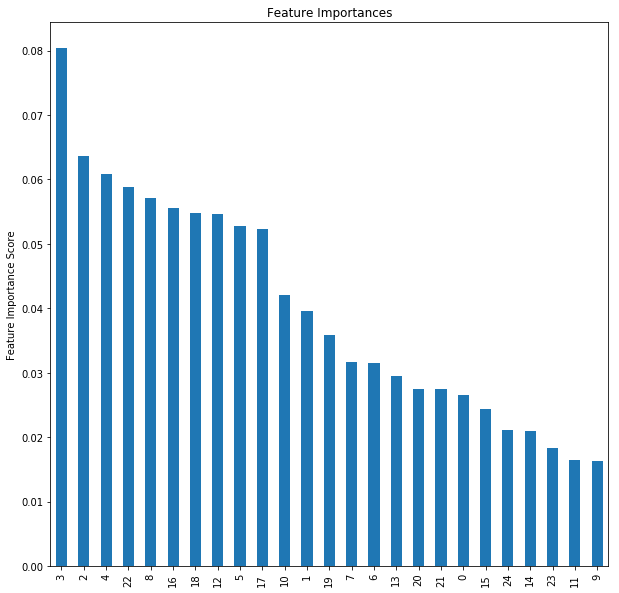

In [14]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train)

In [15]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
print('5:',gsearch5.best_params_, gsearch5.best_score_)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1: {'learning_rate': 0.1, 'n_estimators': 200} 0.7196780303030303


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2: {'max_depth': 3, 'min_child_weight': 1} 0.7222916666666668


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3: {'gamma': 0.8} 0.730094696969697


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4: {'colsample_bytree': 0.85, 'subsample': 0.75} 0.7487878787878788
5: {'reg_alpha': 1e-05} 0.7487878787878788


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7487879 | Std - 0.09940318 | Min - 0.6 | Max - 0.9090909


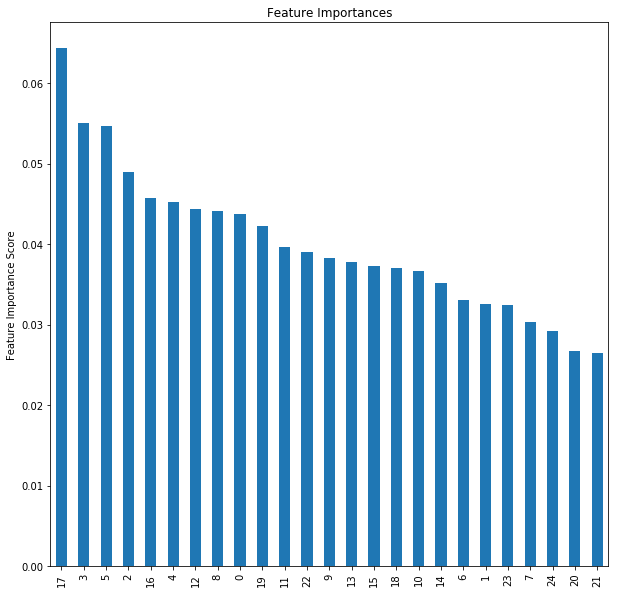

In [16]:
XGB_PCA = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_PCA, X_train, y_train)

In [17]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_PCA
x_prediction = X_val
model = XGB_PCA   
print("# Training 'XGB_PCA'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.21377058 0.9443166  0.6261042  0.8709454  0.989967  ]
- accuracy:  0.5263157894736842
- validation logloss: 0.836527247423012


# Training 'XGB0'
# Predicting...
- probabilities: [0.45441794 0.96469194 0.6788094  0.97267413 0.996305  ]
- accuracy:  0.5789473684210527
- validation logloss: 0.8970541555762267


# Training 'XGB_PCA'
# Predicting...
- probabilities: [0.3297722  0.7947147  0.47375077 0.8551793  0.97392726]
- accuracy:  0.5614035087719298
- validation logloss: 0.7254353203369599


In [18]:
def match(pred,Open,High_Low_Close):
    if pred == 0:
        for n in High_Low_Close:
            if Open >= n:
                return n
        return np.nan
    elif pred == 1:
        for n in High_Low_Close:
            if Open <= n:
                return n
        return np.nan
    
def limit_order(preds,prices):
    trade_prices = [match(preds[i],prices.iloc[i][0],[prices.iloc[i][1], prices.iloc[i][3], prices.iloc[i][2]]) for i in range(len(preds))]
    return trade_prices

In [19]:
#XGB_PCA test_data prediction
model = XGB_PCA
model.fit(X_train, y_train)
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'PCA prediction': results},index=X_test.index)
Close = pd.DataFrame(data={'PCA Trade Price': limit_order(results,CSI300_60)},index=X_test.index)
Open = CSI300_60.Open.loc[list(Close.index)]
prob = prob.join(Close)
prob = prob.join(Open)
prob.index = pd.to_datetime(prob.index)
prob

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PCA prediction,PCA Trade Price,Open
date,,,
2019-10-10 11:30:00,1,3811.73,3851.10
2019-10-10 14:00:00,1,3811.88,3849.84
2019-10-10 15:00:00,1,3820.23,3863.17
2019-10-11 10:30:00,0,3801.81,3885.52
2019-10-11 11:30:00,0,3809.93,3881.60
2019-10-11 14:00:00,1,3812.04,3894.83
2019-10-11 15:00:00,0,3773.61,3910.39
2019-10-14 10:30:00,1,3791.22,3944.86
2019-10-14 11:30:00,1,3781.80,3972.33


In [20]:
# PCA Performance

In [21]:
#assuming zero risk free rate
#sharpe ratio 
#max drawdown
#absolute return
performance_df = pd.DataFrame(index=['Sharpe_Ratio (Daily)','Sharpe_Ratio (Annualized)'])
def performance(prob):
    dates = list(set(prob.index.date))
    returns = []
    for date in dates:
        daily = prob.loc[date.strftime('%Y-%m-%d')]
        Open = daily.iloc[0,2]
        tran_cost = 0.0015
        hun_M = 100000000
        cash = hun_M-hun_M*Open*tran_cost
        Initial_position = hun_M*Open
        share = hun_M
        Investment=[]
        Capital=[Initial_position]
        Prices=[]
        for i in range(len(daily.iloc[:,0])):
            limit_order_price = daily.iloc[i, 1]
            if i!=len(daily.iloc[:, 0])-1 and daily.iloc[i, 0]==1:
                Prices.append(daily.iloc[i, 1])
            if i>0 and daily.iloc[i-1, 0]==0 and daily.iloc[i, 0]==1 and i!=len(daily.iloc[:, 0])-1:
                if cash >= hun_M*limit_order_price*(1+tran_cost):
                    share = hun_M
                    cash -= hun_M*limit_order_price*(1+tran_cost)
                    Capital.append(limit_order_price*share)
                else: 
                    share = cash/(limit_order_price*(1+tran_cost))
                    cash = 0 
                    Capital.append(limit_order_price*share)
            if i>0 and daily.iloc[i-1, 0]==1 and daily.iloc[i, 0]==0:
                Investment.append(limit_order_price*share)
                cash += limit_order_price*share*(1-tran_cost)
                share = 0
                Prices.append(limit_order_price)
            if i==len(daily.iloc[:, 0])-1 and daily.iloc[i, 0]==1 and daily.iloc[i-1, 0]==1:
                Investment.append(limit_order_price*share)
                cash += limit_order_price*share*(1-tran_cost)
                share = 0
                Prices.append(limit_order_price)
        absolute_return=np.log((np.sum(Investment)+cash)/(np.sum(Capital)+hun_M-hun_M*Open*tran_cost))
        returns.append(absolute_return)
    returns = pd.DataFrame(returns).dropna()
    avg_return = np.mean(returns)
    std = np.std(returns)
    Daily_SR = float(avg_return/std)
    SR_ann = float(Daily_SR*(252**0.5))
    return Daily_SR, SR_ann
results = performance(prob)
performance_df['XGB_PCA'] = results
performance_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


,XGB_PCA
Sharpe_Ratio (Daily),5.292605
Sharpe_Ratio (Annualized),84.017498


# Benchmark learning (all features included)

In [22]:
#Standardized Dataset
target = features['target']
All_features = features.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)

In [23]:
#Data Set Preparation 
X_test = X.iloc[int(len(X.index)*0.6):]
X_train = X.iloc[:int(len(X.index)*0.6)]
y_test = Y.iloc[int(len(Y.index)*0.6):]
Y_train = Y.iloc[:int(len(Y.index)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [24]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(132, 51) (132, 1)
(57, 51) (57, 1)
(127, 51) (127, 1)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.8037121 | Std - 0.0533456 | Min - 0.7090909 | Max - 0.8727273


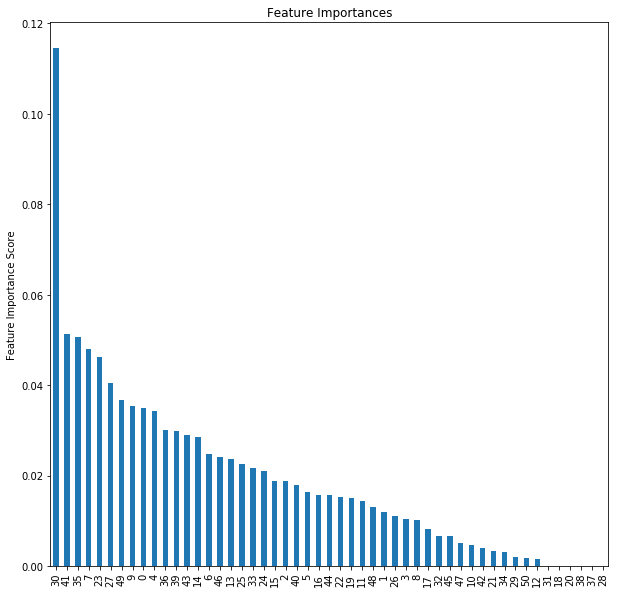

In [25]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train)

In [26]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
print('5:',gsearch5.best_params_, gsearch5.best_score_)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1: {'learning_rate': 0.005, 'n_estimators': 800} 0.8288257575757576


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2: {'max_depth': 4, 'min_child_weight': 1} 0.8336742424242424


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3: {'gamma': 0.0} 0.8336742424242424


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4: {'colsample_bytree': 0.95, 'subsample': 0.95} 0.8367992424242423


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5: {'reg_alpha': 0.01} 0.8378409090909089


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.8378409 | Std - 0.05782646 | Min - 0.769697 | Max - 0.9151515


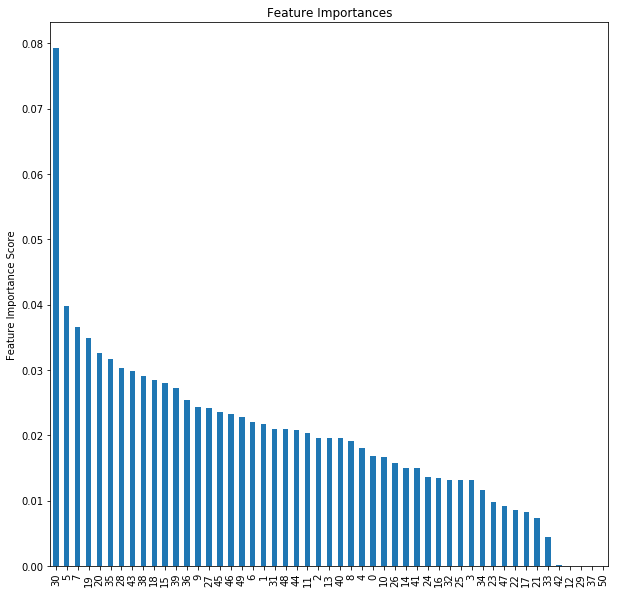

In [27]:
XGB_Bench = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_Bench, X_train, y_train)

In [28]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_Bench
x_prediction = X_val
model = XGB_Bench  
print("# Training 'XGB_Bench'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.17166974 0.64128053 0.43399808 0.25745517 0.99360025]
- accuracy:  0.6666666666666666
- validation logloss: 0.78449355513511


# Training 'XGB0'
# Predicting...
- probabilities: [0.00719647 0.96767074 0.3236968  0.52205557 0.9977449 ]
- accuracy:  0.6491228070175439
- validation logloss: 0.8995475853107086


# Training 'XGB_Bench'
# Predicting...
- probabilities: [0.19260487 0.6636427  0.46504056 0.39149526 0.9638586 ]
- accuracy:  0.7017543859649122
- validation logloss: 0.6226998789791476


 We will pick XGB_Bench as our prediction model, since it performs with better accuracy and lower validation logloss.

In [29]:
#XGB_Bench
model = XGB_Bench
model.fit(X_train, y_train)
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'Benchmark prediction': results},index=X_test.index)
Close = pd.DataFrame(data={'Benchmark Trade Price': limit_order(results,CSI300_60)},index=X_test.index)
Open = CSI300_60.Open.loc[list(Close.index)]
prob = prob.join(Close)
prob = prob.join(Open)
prob.index = pd.to_datetime(prob.index)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
#Benchmark Performance

In [31]:
#assuming zero risk free rate
#sharpe ratio 
#max drawdown
#absolute return
results = performance(prob)
performance_df['XGB_Benchmark'] = results
performance_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


,XGB_PCA,XGB_Benchmark
Sharpe_Ratio (Daily),5.292605,6.011975
Sharpe_Ratio (Annualized),84.017498,95.437146


# PCA_DWT

In [34]:
#Standardized Dataset
target = features['target']
All_features = features.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)

In [35]:
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [5.37343900e-01 2.71812486e-01 5.21549825e-02 3.64046939e-02
 2.05589054e-02 1.77891301e-02 1.38829023e-02 9.75049045e-03
 7.39359949e-03 7.16615065e-03 4.18603899e-03 3.68627664e-03
 2.88186209e-03 2.34142125e-03 2.25331227e-03 2.10513029e-03
 1.60828030e-03 1.39282468e-03 9.28176027e-04 8.29199650e-04
 7.14610234e-04 5.84383264e-04 5.45099790e-04 3.63307013e-04
 2.95950414e-04]
Sum of Explained variation of principal component: 0.9989731137825183


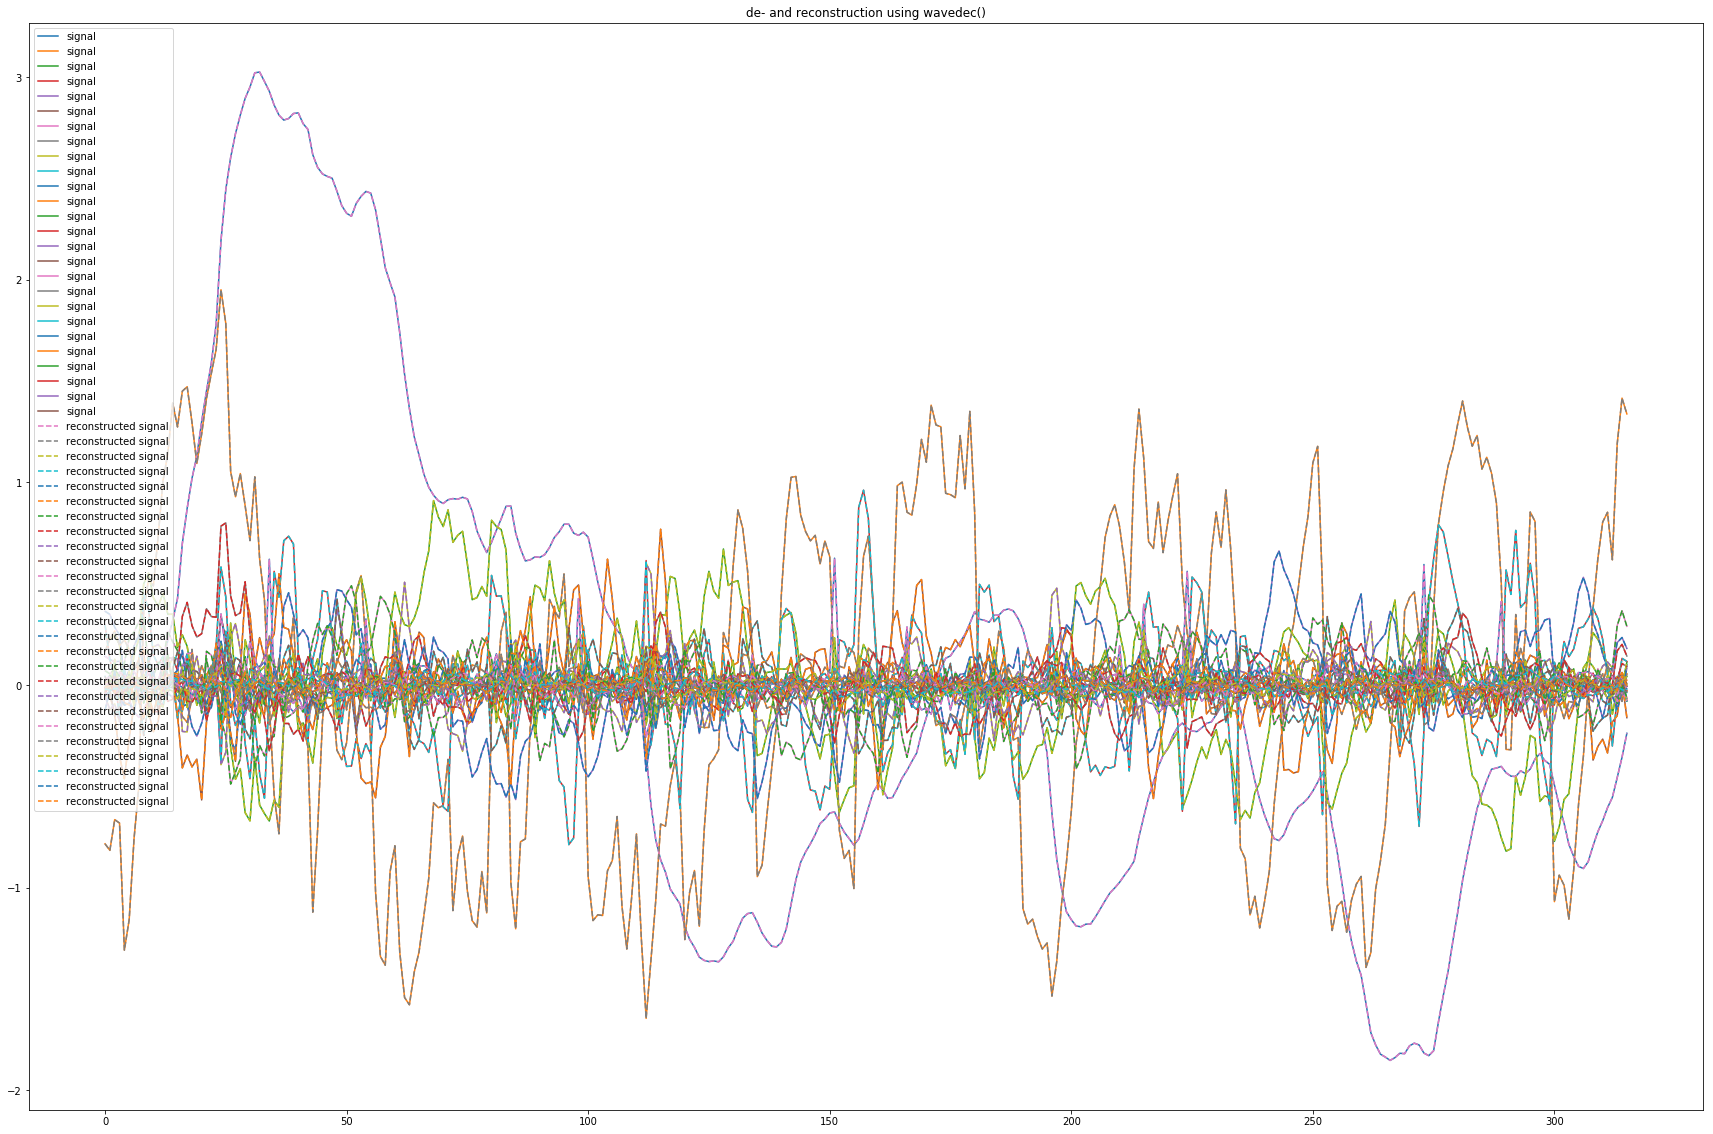

In [36]:
import pywt
coeffs = pywt.wavedec(X, 'db2', level=3)
X = pywt.waverec(coeffs, 'db2')
 
fig, ax = plt.subplots(figsize=(30,20))
ax.plot(X[:1000], label='signal')
ax.plot(X[:1000], label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()

In [37]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [38]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(132, 26) (132, 1)
(57, 26) (57, 1)
(127, 26) (127, 1)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.699072 | Std - 0.06660467 | Min - 0.6 | Max - 0.7818182


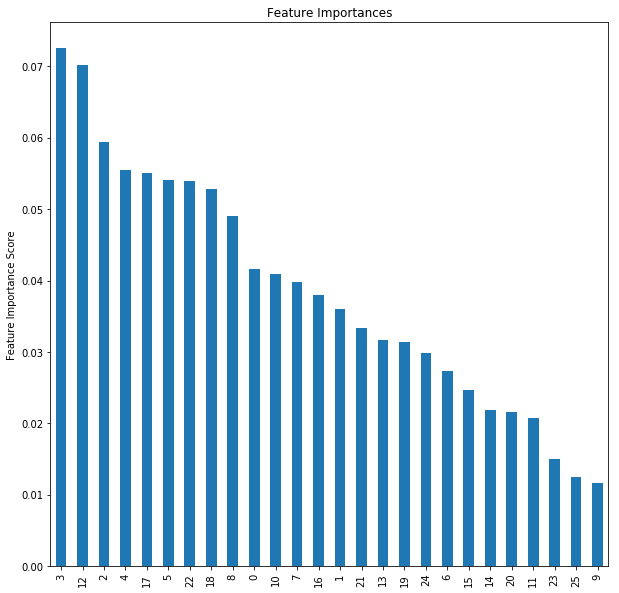

In [39]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train)

In [40]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
print('5:',gsearch5.best_params_, gsearch5.best_score_)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1: {'learning_rate': 0.1, 'n_estimators': 400} 0.7087689393939393


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2: {'max_depth': 4, 'min_child_weight': 1} 0.7139772727272728


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3: {'gamma': 0.3} 0.7326704545454545


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4: {'colsample_bytree': 0.8, 'subsample': 0.75} 0.7401325757575756
5: {'reg_alpha': 0.1} 0.7423863636363636


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7423864 | Std - 0.08002815 | Min - 0.6181818 | Max - 0.8666667


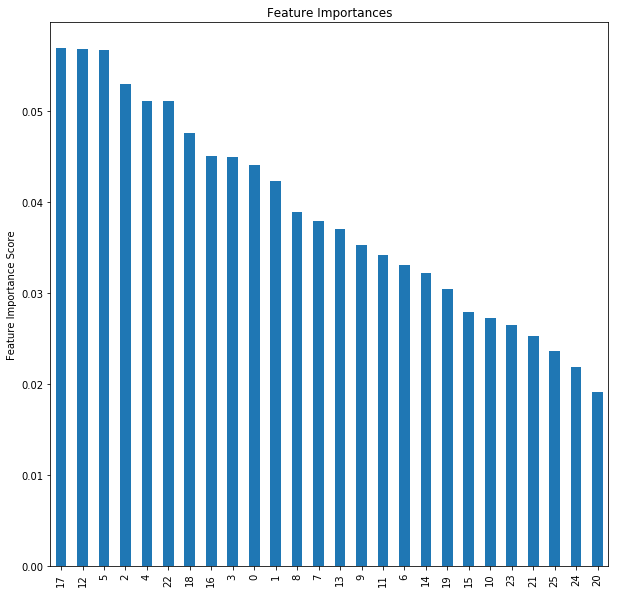

In [42]:
XGB_PCA_DWT = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_PCA_DWT, X_train, y_train)

In [43]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_PCA_DWT
x_prediction = X_val
model = XGB_PCA_DWT  
print("# Training 'XGB_PCA_DWT'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.21377058 0.9443166  0.6261042  0.8709454  0.989967  ]
- accuracy:  0.5263157894736842
- validation logloss: 0.836527247423012


# Training 'XGB0'
# Predicting...
- probabilities: [0.27515137 0.9654398  0.5141785  0.9259032  0.99597305]
- accuracy:  0.5789473684210527
- validation logloss: 0.8581476053978693


# Training 'XGB_PCA_DWT'
# Predicting...
- probabilities: [0.20826095 0.87945634 0.51261115 0.8403201  0.98595816]
- accuracy:  0.543859649122807
- validation logloss: 0.7684269696964245


In [45]:
#XGB_PCA_DWT
#XGB_PCA test_data prediction
model = XGB_PCA_DWT
model.fit(X_train, y_train)
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'XGB_PCA_DWT prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'XGB_PCA_DWT Trade Price': limit_order(results,CSI300_60)},index=y_test.index)
Open = CSI300_60.Open.loc[list(Close.index)]
prob = prob.join(Close)
prob = prob.join(Open)
prob.index = pd.to_datetime(prob.index)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
results = performance(prob)
performance_df['XGB_PCA_DWT'] = results
performance_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


,XGB_PCA,XGB_Benchmark,XGB_PCA_DWT
Sharpe_Ratio (Daily),5.292605,6.011975,4.858514
Sharpe_Ratio (Annualized),84.017498,95.437146,77.126515


# SGD

In [47]:
#Standardized Dataset
target = features['target']
All_features = features.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)

In [48]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(132, 51) (132, 1)
(57, 51) (57, 1)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.9s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.9s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.9s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.3s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.4s finished


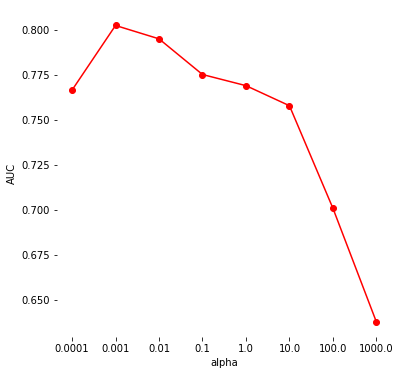

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.8027295285359801


In [49]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [50]:
#Best SGD
x_prediction = X_val
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'SGD prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'SGD Close': limit_order(results,CSI300_60)},index=y_test.index)
Open = CSI300_60.Open.loc[list(Close.index)]
prob = prob.join(Close)
prob = prob.join(Open)
prob.index = pd.to_datetime(prob.index)

# Training...
# Predicting...
- probabilities: [0.38573098 0.73861459 0.46442067 0.60896496 0.95696339]
- accuracy:  0.6842105263157895
- validation logloss: 0.6021845980793588




In [51]:
results = performance(prob)
performance_df['SGD'] = results
performance_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


,XGB_PCA,XGB_Benchmark,XGB_PCA_DWT,SGD
Sharpe_Ratio (Daily),5.292605,6.011975,4.858514,28.870918
Sharpe_Ratio (Annualized),84.017498,95.437146,77.126515,458.311621
